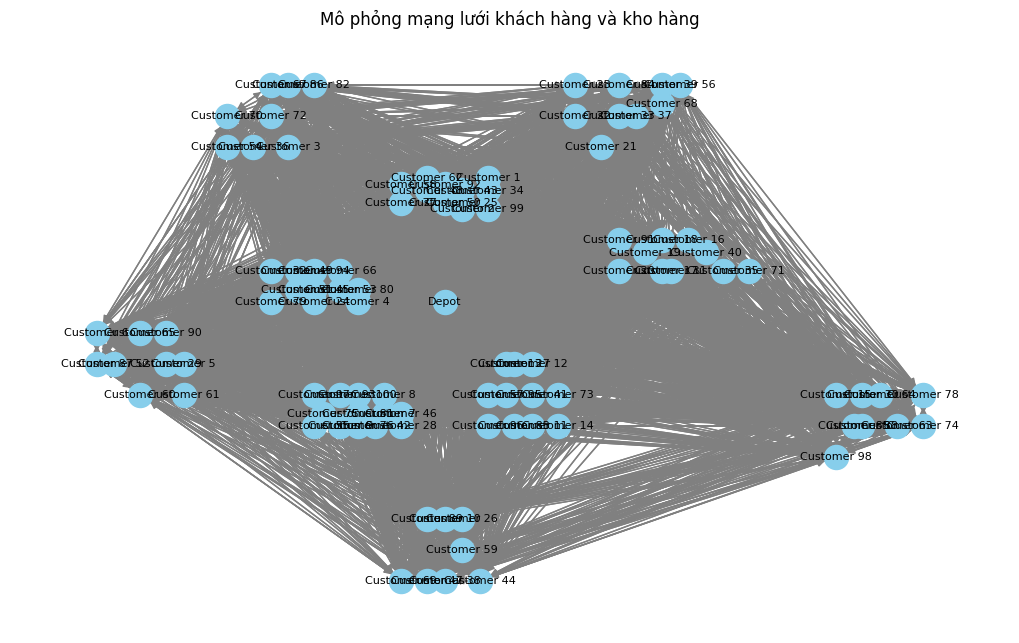

Epoch [0/100], Loss: 0.0000
Epoch [10/100], Loss: 0.0000
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000


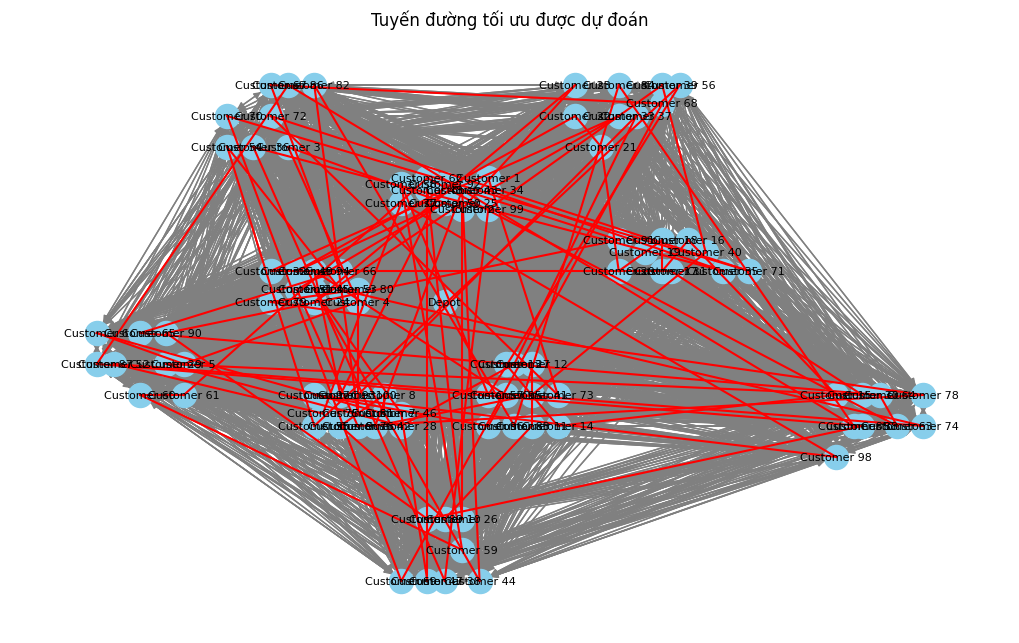

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim

# Đọc file CSV
file_path = "F:/KLTN/100_Customer/h100c101.csv"
df = pd.read_csv(file_path, delimiter=",", header=0)

# Xác định kho hàng và khách hàng
depot = df.iloc[0]
customers = df.iloc[1:].reset_index(drop=True)

# Tọa độ
depot_location = np.array([depot['x'], depot['y']])
customer_locations = customers[['x', 'y']].values

# Trọng lượng hàng và tải trọng xe
demands = customers['demand'].values
truck_capacity = 1300

# Thời gian phục vụ
time_windows = customers[['open', 'close']].values
service_time = 5  # phút
arrival_times = customers['time'].values

# Vận tốc xe
truck_speed = 50 / 60.0  # km/phút

# Tạo đồ thị
G = nx.DiGraph()
G.add_node("Depot", pos=(depot_location[0], depot_location[1]))
for i, (x, y) in enumerate(customer_locations):
    G.add_node(f"Customer {i+1}", pos=(x, y))

edges = []
for i in range(len(customers)):
    for j in range(len(customers)):
        if i != j:
            dist = np.linalg.norm(customer_locations[i] - customer_locations[j])
            edges.append((f"Customer {i+1}", f"Customer {j+1}", dist))

for i in range(len(customers)):
    dist = np.linalg.norm(depot_location - customer_locations[i])
    edges.append(("Depot", f"Customer {i+1}", dist))

G.add_weighted_edges_from(edges)

# Vẽ đồ thị
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray", font_size=8)
plt.title("Mô phỏng mạng lưới khách hàng và kho hàng")
plt.show()

# Mô hình MARDAM
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x, _ = self.attention(x, x, x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Khởi tạo mô hình
model = AttentionModel(input_dim=4, hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Tạo batch dữ liệu đầu vào
    inputs = torch.tensor(np.hstack((customer_locations, time_windows)), dtype=torch.float32)
    outputs = model(inputs.unsqueeze(1))
    
    # Hàm mất mát tối ưu hóa quãng đường
    loss = criterion(outputs, torch.ones_like(outputs))
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# Trực quan hóa tuyến đường tối ưu
predicted_routes = outputs.detach().numpy().flatten()
sorted_indices = np.argsort(predicted_routes)

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", edge_color="gray", font_size=8)
for i in range(len(sorted_indices) - 1):
    plt.plot([customer_locations[sorted_indices[i]][0], customer_locations[sorted_indices[i+1]][0]],
             [customer_locations[sorted_indices[i]][1], customer_locations[sorted_indices[i+1]][1]], 'r-')
plt.title("Tuyến đường tối ưu được dự đoán")
plt.show()
